<a href="https://colab.research.google.com/github/royal-dit/tensorflow-deeplearning/blob/main/bitcoin%20price%20prediction/Google_stock_prediction_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt




In [5]:
df = pd.read_csv('/content/GOOG.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [3]:
df1 = df.reset_index()['Close']

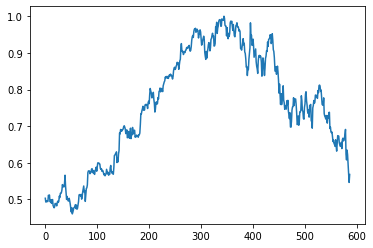

In [16]:
plt.plot(df1[4000:])

In [8]:
df1.shape

(4587,)

In [9]:
scaler =MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(4587, 1)

In [17]:
df1[:5]

array([[5.54588186e-05],
       [1.39474206e-03],
       [1.57790459e-03],
       [8.16681705e-04],
       [1.00656406e-03]])

In [26]:
# train_data = df1[0:training_size,:]

In [27]:
 #splitting our data intotrain test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [30]:
#convert an array value into dataset matrix
def create_dataset(dataset,time_step=1):
  dataX=[]
  dataY =[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)



In [31]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [32]:
#reshape input to be [samples,timesteps,features] which is required for lstm
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [47]:
X_train.shape, y_train.shape,X_test.shape

((2880, 100, 1), (2880,), (1505, 100, 1))

In [35]:
#create an lstm model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [36]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',
              optimizer='adam')




In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=100,batch_size=64,verbose=1)


In [39]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


48/48 [==============================] - 2s 22ms/step


In [40]:
#transformback to orginal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [41]:
#calculate the mse performance metrics

import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

18.848178306215633

In [42]:
math.sqrt(mean_squared_error(y_test,test_predict))

82.58162730386275

 **Plotting the data**

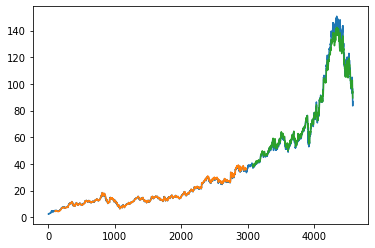

In [45]:
#plotting 
#shift train prediciton for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict

#plot baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**Predict the future 30 days**

In [54]:
len(test_data)

1606

In [56]:
x_input = test_data[1506:].reshape(1,-1)
x_input.shape

(1, 100)

In [59]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input[:10]


[0.7279785631020862,
 0.7026476397580277,
 0.7109428419488372,
 0.7389387369437578,
 0.7390669129335072,
 0.7434557497695946,
 0.782948230872795,
 0.7700246799164261,
 0.7426933664310484,
 0.7405680994924729]

In [ ]:
#demonstrate prediction for next 10 days
from numpy import array
lst_output = []
n_steps = 100
i  = 0
while(i<30):
  if (len(temp_input)>100):
    #print temp input
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input  = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    #print(x_input)
    yhat = model.predict(x_input,verbose = 0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    #print (temp_input)
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1
print(lst_output)

In [62]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)


In [63]:
len(df1)

4587

In [64]:
df3 = df1.tolist()
df3.extend(lst_output)


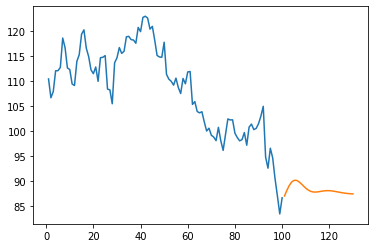

In [65]:
plt.plot(day_new,scaler.inverse_transform(df1[4487:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
